Plotting Positional Encodings...


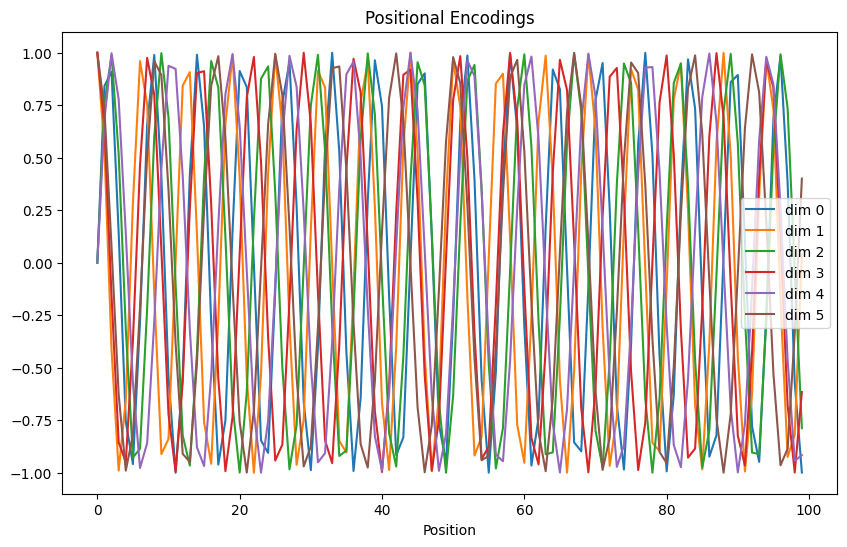

Plotting Attention Weights...


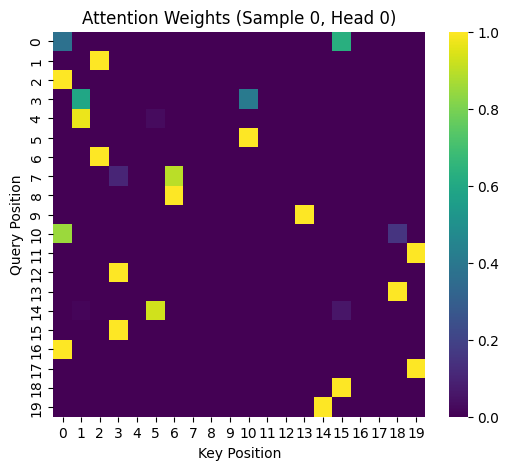

Output shape: torch.Size([1, 20, 128])


In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

    def plot(self, dims=4):
        plt.figure(figsize=(10, 6))
        pos_enc = self.pe[0, :100, :dims]
        for i in range(dims):
            plt.plot(pos_enc[:, i].cpu().numpy(), label=f"dim {i}")
        plt.title("Positional Encodings")
        plt.xlabel("Position")
        plt.legend()
        plt.show()

# Attention with visualization hook
def scaled_dot_product_attention(q, k, v, mask=None, return_attn=False):
    d_k = q.size(-1)
    scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    attn = torch.softmax(scores, dim=-1)
    output = torch.matmul(attn, v)
    return (output, attn) if return_attn else output

# Multi-Head Attention with optional visualization
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, visualize=False):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_k = d_model // num_heads
        self.num_heads = num_heads
        self.visualize = visualize
        self.attn_weights = None  # For visualization

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        q = self.q_linear(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        k = self.k_linear(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        v = self.v_linear(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        if self.visualize:
            output, attn = scaled_dot_product_attention(q, k, v, mask, return_attn=True)
            self.attn_weights = attn.detach()  # Shape: (B, heads, seq, seq)
        else:
            output = scaled_dot_product_attention(q, k, v, mask)

        concat = output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.out(concat)

    def plot_attention(self, index=0, head=0):
        if self.attn_weights is None:
            print("No attention weights stored.")
            return
        attn = self.attn_weights[index, head].cpu().numpy()
        plt.figure(figsize=(6, 5))
        sns.heatmap(attn, cmap="viridis")
        plt.title(f"Attention Weights (Sample {index}, Head {head})")
        plt.xlabel("Key Position")
        plt.ylabel("Query Position")
        plt.show()

# Feed Forward
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(torch.relu(self.linear1(x)))

# Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1, visualize=False):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, visualize)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, d_model, num_layers, num_heads, d_ff, max_len=100, visualize=False):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, visualize=visualize) for _ in range(num_layers)
        ])
        self.d_model = d_model
        self.visualize = visualize

    def forward(self, src, mask=None):
        x = self.embedding(src) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        for layer in self.layers:
            x = layer(x, mask)
        return x

# ==== RUN & VISUALIZE ====
if __name__ == "__main__":
    vocab_size = 1000
    d_model = 128
    num_heads = 4
    d_ff = 512
    num_layers = 1
    max_len = 100
    batch_size = 1
    seq_len = 20

    # Init model with visualization
    model = TransformerEncoder(input_dim=vocab_size, d_model=d_model,
                               num_layers=num_layers, num_heads=num_heads,
                               d_ff=d_ff, max_len=max_len, visualize=True)

    # Dummy input
    src = torch.randint(0, vocab_size, (batch_size, seq_len))
    out = model(src)

    # Plot Positional Encodings
    print("Plotting Positional Encodings...")
    model.pos_encoder.plot(dims=6)

    # Plot Attention from first encoder layer
    print("Plotting Attention Weights...")
    model.layers[0].self_attn.plot_attention(index=0, head=0)

    print("Output shape:", out.shape)
